# Sendit Google Deep Learning Lungren Metrics

This is the second round of sendit, and we want to look at files (or MB) processed per second, and per minute. This is the log produced after running the pipeline for 24 hours, including a couple of manual tester runs (you will see them below in the data). This dataset is different from the first in that there are very few files per compressed image package.

In [1]:
import pandas
from glob import glob
glob('*.tsv')

['sendit-process-time-2017-09-06.tsv']

In [2]:
files = glob('*.tsv')
df = pandas.read_csv(files[0],sep="\t",index_col=0)
done = df[df.status=="DONE"]
print("Folders that are done: %s" %done.shape[0])

Folders that are done: 4920


Above we filter the frame of data collected to those that have a status of DONE. This means we can be confident about a start and finish time being present. 

## Plotting Distributions of MB per Time Unit
Below we will plot first MB per minute, and then MB per second. This is done with 16 cores (each core corresponding to a worker).

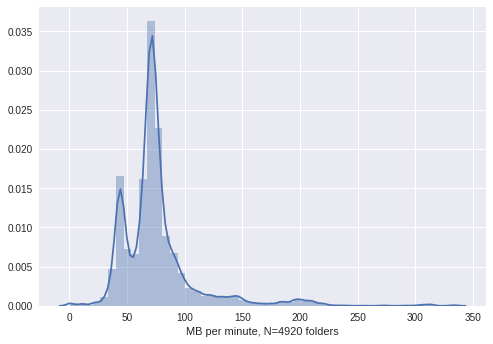

In [3]:
%matplotlib inline
import seaborn as sns
sns.set()
mb_min = done.size_mb / done.total_time_min
ax = sns.distplot(mb_min)
ax.set_xlabel("MB per minute, N=%s folders" %done.shape[0])

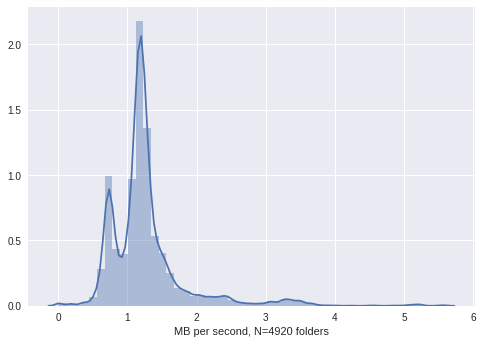

In [4]:
mb_sec = done.size_mb / done.total_time_sec
ax = sns.distplot(mb_sec)
ax.set_xlabel("MB per second, N=%s folders" %done.shape[0])

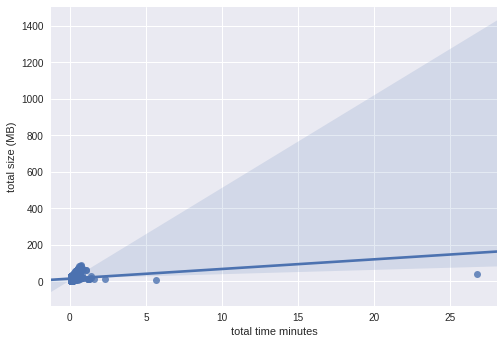

In [5]:
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x=done.total_time_min, y=done.size_mb)
ax.set_xlabel("total time minutes")
ax.set_ylabel("total size (MB)")

Ha, see the two losers on the right? Those are actually test cases that I was (manually) testing. Let's remove them.

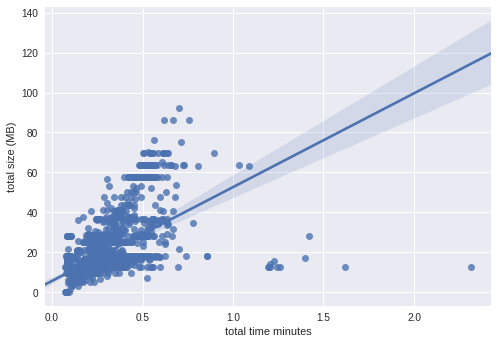

In [7]:
filtered = done[done.total_time_min<5]
ax = sns.regplot(x=filtered.total_time_min, y=filtered.size_mb)
ax.set_xlabel("total time minutes")
ax.set_ylabel("total size (MB)")

In [8]:
filtered.mean()

batch_id          2.691195e+03
size_mb           1.680282e+01
start_time        1.504708e+09
finish_time       1.504708e+09
total_time_sec    1.425862e+01
total_time_min    2.376437e-01
dtype: float64

In [9]:
filtered.std()

batch_id           1439.137116
size_mb               9.965326
start_time        25878.099032
finish_time       25877.233769
total_time_sec        7.634502
total_time_min        0.127242
dtype: float64

Again, for each batch there are anywhere between 1 and 10 images. I would say on average (just glancing at logs) it's usually 2-3, sometimes 4 and 1.